In [1]:
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np
import math

In [2]:
team_codes = ['PHI', 'MIL', 'CHI', 'CLE', 'BOS', 'LAC', 'MEM', 'ATL', 'MIA', 'CHO', 'UTA', 'SAC', 'NYK', 
             'LAL', 'ORL', 'DAL', 'BRK', 'DEN', 'IND', 'NOP', 'DET', 'TOR', 'HOU', 'SAS', 'PHO', 'OKC', 
             'MIN', 'POR', 'GSW', 'WAS']
years = [2018, 2019]


NOTE: Using the http request method vs the urllib method doesn't make a big difference in runtime. Currently, http request method is commented out. 

In [3]:
def get_data(year, team, advanced):
    
    url = "https://www.basketball-reference.com/teams/{}/{}/gamelog-advanced/".format(team, year) if advanced else "https://www.basketball-reference.com/teams/{}/{}/gamelog/".format(team, year)
    page = urlopen(url)
    soup = BeautifulSoup(page, 'lxml')
    #page = requests.get(url)
    #soup = BeautifulSoup(page.content, 'lxml')

    headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
    headers = headers[1:]
    if advanced:
        headers[len(headers)-1] = 'dFT/FGA'
        headers[len(headers)-2] = 'dDRB%'
        headers[len(headers)-3] = 'dTOV%'
        headers[len(headers)-4] = 'deFG%'
    else:
        headers[len(headers)-1] = 'dPF'
    rows = soup.findAll('tr')[2:]
    gamelog = [[td.getText() for td in rows[i].findAll('td')]
                for i in range(len(rows))]

    stats = pd.DataFrame(gamelog, columns = headers)
    stats = stats.dropna()
    stats = stats.reset_index(drop=True)

    stats = stats.loc[:,~stats.columns.duplicated()]
    page.close()
    return stats

def combined_data(year, team):
    basic_table = get_data(year, team, 0)
    advanced_table = get_data(year, team, 1)
    return pd.concat([basic_table, advanced_table], axis=1, sort=False)
    
def big_table():
    frames = []
    for team in team_codes:
        for year in years:
            frames.append(combined_data(year, team))
            
    result = pd.concat(frames, ignore_index=True)
    return result.loc[:,~result.columns.duplicated()]
    


In [4]:
temp = big_table()

In [22]:
data1 = ['Tm', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST',
       'PF', 'dPF']
data2 = ['Tm', 'ORtg', 'DRtg', 'Pace', 'FTr',
       '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%', 'ORB%',
       'FT/FGA', 'deFG%', 'dTOV%', 'dDRB%', 'dFT/FGA', 'FG', '3P']
for x in data1:
    temp[x] = pd.to_numeric(temp[x], downcast='float')
for x in data2:
    temp[x] = pd.to_numeric(temp[x], downcast='float')
    
temp['2P'] = temp['FG'] - temp['3P']
temp['2PA'] = temp['FGA'] - temp['3PA']
temp['2P%'] = temp['2P']/temp['2PA']

    
data1.append('2P')
data1.append('2PA')
data1.append('2P%')
data2.append('2P')
data2.append('2PA')
data2.append('2P%')
temp[data1].corr()

,Tm,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,PF,dPF,2P,2PA,2P%
Tm,1.000000,0.846016,0.333783,0.697524,0.512616,0.223511,0.485915,0.317082,0.275733,0.148915,0.055868,0.151986,0.598109,0.197630,0.219735,0.474270,0.096150,0.518528
FG,0.846016,1.000000,0.463739,0.774318,0.321288,0.055968,0.383137,-0.157738,-0.162608,-0.009713,0.050793,0.131589,0.653447,0.087147,-0.113067,0.756990,0.345976,0.611685
FGA,0.333783,0.463739,1.000000,-0.196833,0.116880,0.292369,-0.123293,-0.176675,-0.166233,-0.053827,0.537403,0.435740,0.222181,0.085400,-0.074479,0.373204,0.602820,-0.169588
FG%,0.697524,0.774318,-0.196833,1.000000,0.272389,-0.144444,0.513022,-0.047302,-0.060102,0.027767,-0.322385,-0.162278,0.563085,0.034415,-0.071934,0.569860,-0.046155,0.800110
3P,0.512616,0.321288,0.116880,0.272389,1.000000,0.703646,0.693179,-0.094294,-0.107197,0.024153,-0.058414,0.029739,0.436187,0.042535,-0.110537,-0.375571,-0.488106,0.048578
3PA,0.223511,0.055968,0.292369,-0.144444,0.703646,1.000000,0.004250,-0.058918,-0.062130,0.003920,0.106166,0.143354,0.212124,0.045033,-0.048216,-0.430748,-0.586768,0.086345
3P%,0.485915,0.383137,-0.123293,0.513022,0.693179,0.004250,1.000000,-0.069856,-0.085560,0.032836,-0.184587,-0.098344,0.389737,0.015663,-0.105546,-0.103331,-0.107944,-0.016409
FT,0.317082,-0.157738,-0.176675,-0.047302,-0.094294,-0.058918,-0.069856,1.000000,0.929364,0.315545,0.065010,0.072527,-0.146637,0.238140,0.727275,-0.089311,-0.100444,-0.003492
FTA,0.275733,-0.162608,-0.166233,-0.060102,-0.107197,-0.062130,-0.085560,0.929364,1.000000,-0.033893,0.102399,0.101069,-0.157029,0.254328,0.794633,-0.085174,-0.088921,-0.010481
FT%,0.148915,-0.009713,-0.053827,0.027767,0.024153,0.003920,0.032836,0.315545,-0.033893,1.000000,-0.081888,-0.055476,0.010720,-0.003043,-0.053231,-0.026172,-0.048849,0.018336


In [18]:
temp[data2].corr()

,Tm,ORtg,DRtg,Pace,FTr,3PAr,TS%,TRB%,AST%,STL%,...,ORB%,FT/FGA,deFG%,dTOV%,dDRB%,dFT/FGA,FG,3P,2P,2PA
Tm,1.000000,0.862146,0.136818,0.386374,0.175108,0.107270,0.764305,0.295933,0.126007,0.004005,...,0.180686,0.218351,0.082039,-0.070878,0.018131,0.129889,0.846016,0.512616,0.474270,0.096150
ORtg,0.862146,1.000000,0.174269,-0.055488,0.120519,0.108584,0.845866,0.336270,0.129867,-0.028348,...,0.261572,0.182505,0.079106,-0.129129,-0.035302,0.081547,0.743089,0.503123,0.380088,-0.050600
DRtg,0.136818,0.174269,1.000000,-0.055488,0.067270,0.000317,0.096807,-0.336175,-0.051179,-0.239518,...,0.035284,0.081547,0.814956,-0.296352,-0.261614,0.182505,0.092869,0.046849,0.058563,0.018809
Pace,0.386374,-0.055488,-0.055488,1.000000,0.152249,0.026149,0.043135,0.000011,0.041760,0.080987,...,-0.127681,0.125505,0.025731,0.115265,0.127681,0.125505,0.299442,0.090260,0.230778,0.206158
FTr,0.175108,0.120519,0.067270,0.152249,1.000000,0.014096,0.166642,0.037870,-0.056423,0.007543,...,0.006795,0.939185,0.002151,-0.011016,-0.043524,0.146445,-0.262701,-0.127658,-0.169015,-0.228388
3PAr,0.107270,0.108584,0.000317,0.026149,0.014096,1.000000,0.164618,-0.040055,0.270386,-0.025559,...,-0.100530,0.018086,-0.007726,-0.050521,0.021905,-0.036688,-0.114671,0.688304,-0.587163,-0.834042
TS%,0.764305,0.845866,0.096807,0.043135,0.166642,0.164618,1.000000,0.261070,0.207653,-0.007802,...,-0.058889,0.231582,0.021723,-0.097487,-0.015339,0.038083,0.643128,0.506442,0.279968,-0.288565
TRB%,0.295933,0.336270,-0.336175,0.000011,0.037870,-0.040055,0.261070,1.000000,0.029128,-0.144000,...,0.608007,0.057241,-0.249958,-0.178283,0.607960,-0.057230,0.280850,0.094104,0.209930,0.068504
AST%,0.126007,0.129867,-0.051179,0.041760,-0.056423,0.270386,0.207653,0.029128,1.000000,0.004979,...,-0.088922,-0.049846,-0.049000,-0.027446,0.032928,-0.042275,0.079212,0.320802,-0.143833,-0.254106
STL%,0.004005,-0.028348,-0.239518,0.080987,0.007543,-0.025559,-0.007802,-0.144000,0.004979,1.000000,...,0.002992,0.006182,0.024985,0.733138,-0.108157,0.014505,0.012634,-0.037757,0.038417,0.026422


In [10]:

temp.head()

,G,Date,,Opp,W/L,Tm,FG,FGA,FG%,3P,...,eFG%,TOV%,ORB%,FT/FGA,deFG%,dTOV%,dDRB%,dFT/FGA,2P,2PA
0,1,2017-10-18,@,WAS,L,115.0,43.0,93.0,0.462,15.0,...,0.543,14.400000,23.400000,0.151,0.464,7.300000,69.800003,0.309,28.0,58.0
1,2,2017-10-20,,BOS,L,92.0,35.0,92.0,0.380,10.0,...,0.435,13.900000,25.500000,0.130,0.476,16.200001,70.199997,0.262,25.0,60.0
2,3,2017-10-21,@,TOR,L,94.0,32.0,82.0,0.390,8.0,...,0.439,17.000000,15.700000,0.268,0.545,11.000000,80.500000,0.348,24.0,58.0
3,4,2017-10-23,@,DET,W,97.0,35.0,75.0,0.467,9.0,...,0.527,19.700001,21.100000,0.240,0.424,13.000000,82.000000,0.165,26.0,51.0
4,5,2017-10-25,,HOU,L,104.0,43.0,97.0,0.443,12.0,...,0.505,12.100000,26.700001,0.062,0.560,18.200001,81.599998,0.280,31.0,61.0


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [12]:
full_train, full_test, y_train, y_test = train_test_split(temp, temp['Tm'], test_size=0.2, random_state=42)

In [16]:
# predict team's FT using (how many FT opposing team is allowing per game and how many team is taking per game)*team's FT%

# predict 2P using AST, 2PA, Pace, 2P%
# predict 3P using AST, 3PA, Pace, 3P%

X = full_train[['FTA']]
X_test = full_test[['FTA']]
y = full_train['FT']
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

0.8618989710063512


In [ ]:
df = get_data(2019, 'HOU', 0)
df['FT%'] = pd.to_numeric(df['FT%'], downcast='float')
plot.hist(df['FT%'])

In [ ]:
data1 = ['Tm', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'dPF']
data2 = ['Tm', 'ORtg', 'DRtg', 'Pace', 'FTr',
       '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%', 'ORB%',
       'FT/FGA', 'deFG%', 'dTOV%', 'dDRB%', 'dFT/FGA', 'FG', '3P']
for x in data1:
    df[x] = pd.to_numeric(df[x], downcast='float')
for x in data2:
    df[x] = pd.to_numeric(df[x], downcast='float')

In [ ]:
X = full_train[['ORtg','FG', '3P','TS%','eFG%', 'FT']]
X_test = full_test[['ORtg','FG', '3P','TS%', 'eFG%', 'FT']]
reg = LinearRegression().fit(X, y_train)
print(reg.score(X, y_train))

print(reg.score(X_test, y_test))

In [ ]:
X = full_train[['ORtg', 'eFG%']]
reg = LinearRegression().fit(X, y_train)
print(reg.score(X, y_train))

(array([  33.,  447.,  817., 1552.,  914.,  751.,  316.,   56.,   31.,
           3.]),
 array([ 0. ,  2.6,  5.2,  7.8, 10.4, 13. , 15.6, 18.2, 20.8, 23.4, 26. ]),
 <a list of 10 Patch objects>)

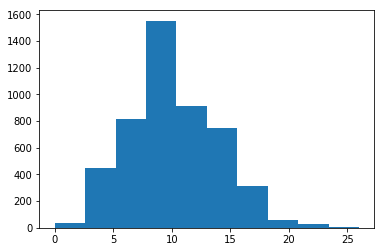

In [23]:
plot.hist(temp['ORB'])